Results from SCARGC algorithm (for boxplot and accuracy timelime).
One Class Horizontal Translation. 2 Dimensional data.
100 batches of 158 instances



METHOD: Microcluster(BIRCH) as classifier
Accuracy:  47.0402038054
Average execution time:  0.436788988216
Average Accuracy:  47.0402038054
Standard Deviation:  5.11352646105
Variance:  26.1481528678


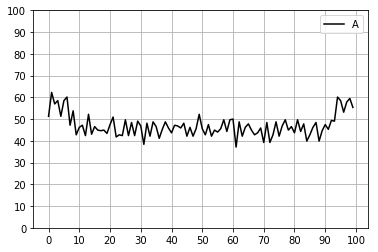

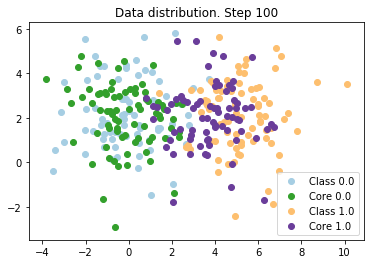




SCARGC accuracy:  94.0676886792
Boxplots from all methods


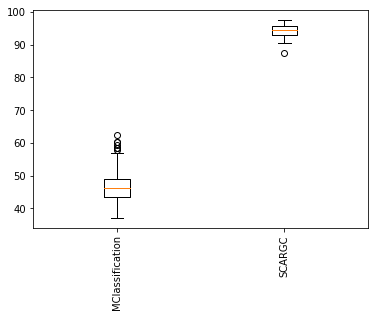

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[1])

import matplotlib.pyplot as plt
from source import plotFunctions
from timeit import default_timer as timer
import numpy as np
import setup
from source import metrics
from methods import sliding_knn
from methods import microcluster
from methods import microcluster2
from methods import microcluster3

%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import Audio, display



class Experiment():
    def __init__(self, method):
        #commom for all experiments
        self.method = method
        #self.initialLabeledDataPerc=0.05 #150 instances for keystroke database and 0.05 % for artificial databases
        #self.classes=[0, 1]
        self.usePCA=False
        #used only by gmm / kde process
        self.densityFunction='gmm'
        self.excludingPercentage = 0.9
        self.K_variation = 2
        self.classifier='cluster_and_label'
        #used in alpha-shape version only
        self.CP=0.65
        self.alpha=0.5
        #used in kmeans_svm and compose only
        self.useSVM=False
        self.isImbalanced=False


def doExperiments(dataValues, dataLabels, datasetDescription, arrAccSCARGC, finalAccSCARGC, experiments, numberOfTimes, batches, labeledData, poolSize, isBatchMode):
    listOfAccuracies = []
    listOfMethods = []
    sizeOfBatch = int((len(dataLabels)-labeledData)/batches)#int(len(dataLabels)/batches)
    
    print(datasetDescription)
    print("{} batches of {} instances".format(batches, sizeOfBatch))
    print("\n\n")
    
    for name, e in experiments.items():
        CoreX = []
        CoreY = []
        elapsedTime = []
        accTotal = []
        accuracies=[]
        classes = np.unique(dataLabels)#getting all possible classes existent in data
        e.sizeOfBatch = sizeOfBatch
        e.batches = batches
        e.dataLabels = dataLabels
        e.dataValues = dataValues
        e.clfName = 'knn' #rf = random forests, cl = cluster and label, knn = k-nn, svm = svm

        for i in range(numberOfTimes):
            start = timer()
            #accuracy per step
            algorithmName, accuracies, CoreX, CoreY = e.method.start(dataValues=e.dataValues, dataLabels=e.dataLabels, 
                                                                     usePCA=e.usePCA, classes=classes, classifier=e.classifier, 
                                                                     densityFunction=e.densityFunction, batches=e.batches, 
                                                                     sizeOfBatch = e.sizeOfBatch, initialLabeledData=labeledData, 
                                                                     excludingPercentage=e.excludingPercentage, 
                                                                     K_variation=e.K_variation, CP=e.CP, alpha=e.alpha, 
                                                                     clfName=e.clfName , useSVM=e.useSVM, isImbalanced=e.isImbalanced, 
                                                                     poolSize=poolSize, isBatchMode=isBatchMode)
            end = timer()
            averageAccuracy = np.mean(accuracies)

            #elapsed time per step
            elapsedTime.append(end - start)
            
            accTotal.append(averageAccuracy)
        
        listOfAccuracies.append(accuracies)
        listOfMethods.append(algorithmName)
        #print("Total of ", numberOfTimes, " experiment iterations with an average accuracy of ", np.mean(accTotal))
        print("Average execution time: ", np.mean(elapsedTime))
        metrics.finalEvaluation(accuracies, batches)
    
        #print data distribution in step t
        initial = (batches*sizeOfBatch)-sizeOfBatch
        final = initial + sizeOfBatch
        plotFunctions.plot(dataValues[initial:final], dataLabels[initial:final], CoreX, CoreY, batches)
        print("\n\n")
    print("SCARGC accuracy: ",finalAccSCARGC)
    listOfAccuracies.append(arrAccSCARGC)
    listOfMethods.append("SCARGC")
    
    plotFunctions.plotBoxplot(listOfAccuracies, listOfMethods)
    
        
def accSCARGC(path, sep, key, steps):
    
    resultsSCARGC_1, resultsSCARGC_2 = setup.loadSCARGCBoxplotResults(path, sep)
    res = resultsSCARGC_1[key]
    res = [ res[i::steps] for i in range(steps) ]
    arrAcc = []
    for i in range(steps):
        arrAcc.append(sum(res[i])/len(res[i])*100)
        #print(r[i])
    #print(sum(r)/steps)
    finalAcc = sum(arrAcc)/steps
    return arrAcc, finalAcc



def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    initialLabeledData = 150
    steps = 100
    poolSize = 159
    isBatchMode = False
    arrAccSCARGC, finalAccSCARGC = accSCARGC(path, sep, '2CDT', steps)
    
    #sinthetic
    dataValues, dataLabels, description = setup.loadCDT(path, sep)
    dataValues, dataLabels, description = setup.loadCHT(path, sep)
    '''dataValues, dataLabels, description = setup.load2CDT(path, sep)
    dataValues, dataLabels, description = setup.load2CHT(path, sep)
    dataValues, dataLabels, description = setup.load4CR(path, sep)
    dataValues, dataLabels, description = setup.load4CRE_V1(path, sep)
    dataValues, dataLabels, description = setup.load4CRE_V2(path, sep)
    dataValues, dataLabels, description = setup.load5CVT(path, sep)
    dataValues, dataLabels, description = setup.loadCSurr(path, sep)
    dataValues, dataLabels, description = setup.load4CE1CF(path, sep)
    dataValues, dataLabels, description = setup.loadUG_2C_2D(path, sep)
    dataValues, dataLabels, description = setup.loadMG_2C_2D(path, sep)
    dataValues, dataLabels, description = setup.loadFG_2C_2D(path, sep)
    dataValues, dataLabels, description = setup.loadUG_2C_3D(path, sep)
    dataValues, dataLabels, description = setup.loadUG_2C_5D(path, sep)
    dataValues, dataLabels, description = setup.loadGEARS_2C_2D(path, sep)
    dataValues, dataLabels, description = setup.loadCheckerBoard(path, sep)
    #real
    dataValues, dataLabels, description = setup.loadKeystroke(path, sep)
    dataValues, dataLabels, description = setup.loadNOAADataset(path, sep)
    dataValues, dataLabels, description = setup.loadElecData(path, sep)'''
    
    
    experiments[1] = Experiment(microcluster)
    #experiments[2] = Experiment(microcluster2) #sem condições, demorando demais (MAIS DE UM DIA)
    #experiments[3] = Experiment(microcluster3) # uma hora e meia pra processar 16000 pontos
    
    
    #running pywidget
    '''
    def run(batches):
        doExperiments(dataValues, dataLabels, description, experiments, 1, batches, 6250)
        
    v = interact(run, batches=(1, 100, 1)); #8 batches for keystroke and 100 batches for artificial datasets
    display(v)
    '''
    #params: X, y, method, num of experiment repetitions, num of batches, num of labeled data
    doExperiments(dataValues, dataLabels, description, arrAccSCARGC, finalAccSCARGC, experiments, 1, steps, initialLabeledData, poolSize, isBatchMode)
    
    
    
if __name__ == "__main__":
    main()

In [2]:
import numpy as np
a = [[1, 2], [3, 4], [4, 5]]

b = 2 * np.array(a)
c = np.array([1, 4, 2, 1, 3])
d = (-c).argsort()[:2]
e = np.random.randint(2, size=1)
e

array([1])